# Kernel-based Time-varying Regression - Part II

In previous tutorial, we learnt basic syntax and structure of **KTR** (or so called **BTVC**). We will shift the discussion to a regression problem.  

Here in **Part I**, we will cover

1. KTR model structure with regression
2. Syntax to initialize, fit and predict a model
3. Fit a model with regression component
4. Visualization of knots and regression coefficients

In [9]:
import pandas as pd
import numpy as np
from math import pi
import matplotlib.pyplot as plt

import orbit
from orbit.models import KTR
from orbit.utils.features import make_fourier_series_df, make_fourier_series
from orbit.diagnostics.plot import plot_predicted_components

%matplotlib inline
pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
print(orbit.__version__)

1.0.16dev


## Model Structure

Our goal is to derive an additive form such that 

$$y_t = l_t + s_t + r_t + \epsilon_t,  ~ t = 1,\cdots, T,$$

where $y_t$ is the response variable, $l_t$ is the trend term,  $s_t$ is the seasonality term and $r_t$ is the regression term.

For details of how we we derive $l_t$ and $s_t$, please refer to **Part I**.

Recall in **KTR**, we express regression coefficients $\beta$ as such

$$\beta=Kb^T$$

where

- *knot matrix* $b$ with size $P\times J$  where each entry is a latent vairable  $b_{p, j}$ can be viewed as the "knots" from the perspective of spline regression and
$j$ is a time index such that $t_j \in [1, \cdots, T]$.
- *kernel matrix*  $K$  with size $T\times J$ where the $i$th row and $j$th element can be viewed as the noramlied weight $k(t_j, t) / \sum_{j=1}^{J} k(t_j, t)$

In regression, we generate the matrix $K$ with Gaussian kernel $k_\text{reg}$ as such:

$k_\text{reg}(t, t_j;\rho) = \exp ( -\frac{(t-t_j)^2}{2\rho^2}  ),$

where $\rho$ is the scale hyper-parameter.

## Data Simulation Module

In this example, we will use simulated data in order to have true regression coefficients for comparison.  We propose two set of simulations with three predictors:

- random walk
- sine-cosine like 

In [10]:
def sim_data_seasonal(n, RS):
    """ coefficients curve are sine-cosine like
    """
    np.random.seed(RS)
    # make the time varing coefs  
    tau = np.arange(1, n+1)/n
    data = pd.DataFrame({
        'tau': tau,
        'date': pd.date_range(start='1/1/2018', periods=n),
        'beta1': 2 * tau,
        'beta2': 1.01 + np.sin(2*pi*tau),
        'beta3': 1.01 + np.sin(4*pi*(tau-1/8)),
        'x1': np.random.normal(0, 10, size=n),
        'x2': np.random.normal(0, 10, size=n),
        'x3': np.random.normal(0, 10, size=n),
        'trend': np.cumsum(np.concatenate((np.array([1]), np.random.normal(0, 0.1, n-1)))),
        'error': np.random.normal(0, 1, size=n) #stats.t.rvs(30, size=n),#
    })
        
    data['y'] = data.x1 * data.beta1 + data.x2 * data.beta2 + data.x3 * data.beta3 + data.error
    return data

def sim_data_rw(n, RS, p=3):
    """ coefficients curve are sine-cosine like
    """
    np.random.seed(RS)

    # initializing coefficients at zeros, simulate all coefficient values
    lev = np.cumsum(np.concatenate((np.array([5.0]), np.random.normal(0, 0.01, n-1))))
    beta = np.concatenate(
        [np.random.uniform(0.05, 0.12, size=(1,p)),
         np.random.normal(0.0, 0.01, size=(n-1,p))], 
            axis=0)
    beta = np.cumsum(beta, 0)

    # simulate regressors
    covariates = np.random.normal(0, 10, (n, p))

    # observation with noise
    y = lev + (covariates * beta).sum(-1) + 0.3 * np.random.normal(0, 1, n)

    regressor_col = ['x{}'.format(pp) for pp in range(1, p+1)]
    data = pd.DataFrame(covariates, columns=regressor_col)
    beta_col = ['beta{}'.format(pp) for pp in range(1, p+1)]
    beta_data = pd.DataFrame(beta, columns=beta_col)
    data = pd.concat([data, beta_data], axis=1)
        
    data['y'] = y
    data['date'] = pd.date_range(start='1/1/2018', periods=len(y))

    return data

### Random Walk Dataset

In [12]:
rw_data = sim_data_rw(n=300, RS=8888, p=3)
rw_data.head(10)

,x1,x2,x3,beta1,beta2,beta3,y,date
0,1.11869,12.57944,-18.70548,0.08383,0.11804,0.10688,4.23824,2018-01-01
1,0.25149,5.30067,8.97456,0.08158,0.11665,0.11608,6.76230,2018-01-02
2,-12.53590,2.13434,4.22410,0.08384,0.11274,0.12169,4.57635,2018-01-03
3,-6.83038,3.09457,-1.92619,0.06779,0.11135,0.12628,4.49756,2018-01-04
4,-3.37015,3.89962,-3.08311,0.08633,0.09988,0.13899,5.23037,2018-01-05
5,-3.36446,-4.18615,13.14925,0.07620,0.10859,0.14255,6.10277,2018-01-06
6,-3.66356,-14.79541,-1.73128,0.09153,0.09901,0.15621,3.28499,2018-01-07
7,7.20599,-5.62337,-11.80655,0.10095,0.09951,0.16008,2.52902,2018-01-08
8,-3.64366,3.79963,-1.39817,0.10064,0.08795,0.16389,4.90898,2018-01-09
9,9.22233,1.69517,-0.89649,0.09850,0.08597,0.17241,5.52978,2018-01-10


Let's derive some metadata for fitting purpose.

In [30]:
# num of predictors
p = 3
regressor_col = ['x{}'.format(pp) for pp in range(1, p + 1)]
response_col = 'y'
date_col='date'

Unlike fitting a model without regressors, we need to supply additional args to describe the priors for regression. After the initialization, the fit-and-predict would be similar to models without regressors.

In [26]:
ktr = KTR(
    response_col=response_col,
    date_col=date_col,
    
    level_knot_scale=0.1,
    regressor_col=regressor_col,
    regressor_init_knot_loc=[0] * len(regressor_col),
    regressor_init_knot_scale=[1.0] * len(regressor_col),
    regressor_knot_scale=[0.5] * len(regressor_col),
    regression_segments=5,

    prediction_percentiles=[2.5, 97.5],
    seed=2020,

    estimator='pyro-svi'
)

In [27]:
ktr.fit(df=rw_data)

INFO:root:Guessed max_plate_nesting = 1


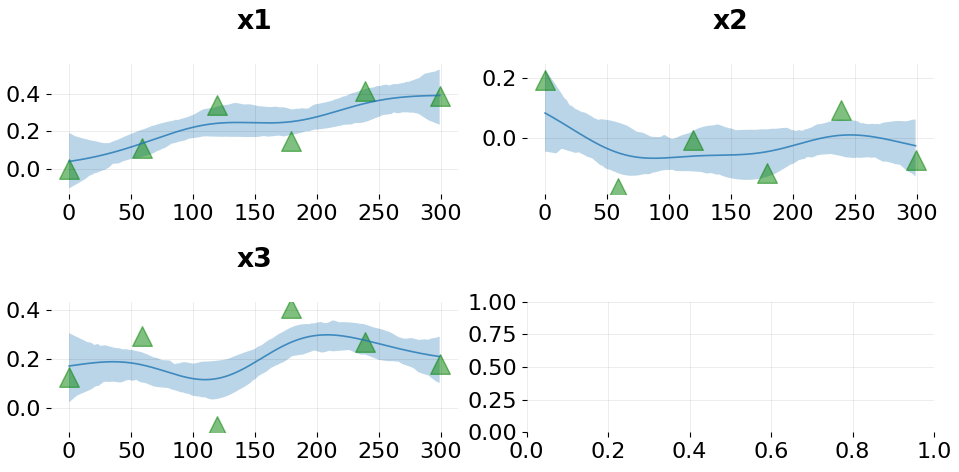

In [29]:
ktr.plot_regression_coefs(with_knot=True, figsize=(10, 5), include_ci=True);

In [31]:
coef_mid, coef_lower, coef_upper  = ktr.get_regression_coefs(include_ci=True, coefficient_method='empirical')

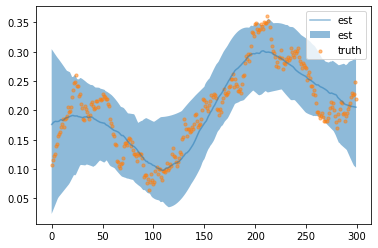

In [32]:
idx = 3

x = np.arange(coef_mid.shape[0])

plt.plot(x, coef_mid['x{}'.format(idx)], label='est', alpha=0.5)
plt.fill_between(x, coef_lower['x{}'.format(idx)], coef_upper['x{}'.format(idx)], label='est', alpha=0.5)
plt.scatter(x, rw_data['beta{}'.format(idx)], label='truth', s=10, alpha=0.5)
plt.legend();

In [11]:
seas_data = sim_data_seasonal(n=1000, RS=8888)
seas_data.head(10)

,tau,date,beta1,beta2,beta3,x1,x2,x3,trend,error,y
0,0.00100,2018-01-01,0.00200,1.01628,0.01008,-4.11220,6.23525,8.31807,1.00000,-0.77202,5.64037
1,0.00200,2018-01-02,0.00400,1.02257,0.01032,-0.49928,-14.81601,3.64103,1.07515,1.24357,-13.87121
2,0.00300,2018-01-03,0.00600,1.02885,0.01071,1.82603,-2.89778,-17.14413,1.27849,-0.35215,-3.50620
3,0.00400,2018-01-04,0.00800,1.03513,0.01126,24.87474,5.43950,6.05519,1.10474,-0.57194,5.32585
4,0.00500,2018-01-05,0.01000,1.04141,0.01197,1.73458,-16.38398,9.07501,1.05908,-0.21802,-17.15447
5,0.00600,2018-01-06,0.01200,1.04769,0.01284,-11.05969,12.49470,2.57794,1.08820,0.54140,13.53236
6,0.00700,2018-01-07,0.01400,1.05397,0.01387,-6.06592,4.60646,-9.18224,1.15337,0.47460,5.11741
7,0.00800,2018-01-08,0.01600,1.06024,0.01505,0.94524,3.45029,13.37669,1.24468,2.12243,5.99701
8,0.00900,2018-01-09,0.01800,1.06652,0.01639,11.62823,11.26265,16.72255,1.16751,0.43905,12.93424
9,0.01000,2018-01-10,0.02000,1.07279,0.01789,2.74087,2.27104,-17.40526,1.35274,0.49626,2.67613
